In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from ml_toolkit.eda import smooth1D
from scipy import stats
from scipy.special import inv_boxcox
from numpy.random import uniform
from sklearn.preprocessing import RobustScaler
from pandas.api.types import is_numeric_dtype

df = pd.read_csv("housing.csv")

us = uniform(size=len(df))
df_test = df[us>0.8]
df = df[us<=.8]

In [3]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16452 entries, 2 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16452 non-null  float64
 1   latitude            16452 non-null  float64
 2   housing_median_age  16452 non-null  float64
 3   total_rooms         16452 non-null  float64
 4   total_bedrooms      16287 non-null  float64
 5   population          16452 non-null  float64
 6   households          16452 non-null  float64
 7   median_income       16452 non-null  float64
 8   median_house_value  16452 non-null  float64
 9   ocean_proximity     16452 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16452.000000,16452.000000,16452.000000,16452.000000,16287.000000,16452.000000,16452.000000,16452.000000,16452.000000
mean,-119.560487,35.620417,28.678033,2631.636458,537.322159,1424.485594,499.103088,3.866337,207055.888099
std,2.003304,2.130772,12.545044,2150.578553,417.566801,1113.021305,378.303208,1.900490,115457.269012
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1451.000000,297.000000,791.000000,281.000000,2.565175,120000.000000
50%,-118.480000,34.250000,29.000000,2130.500000,435.000000,1169.000000,410.000000,3.531300,179750.000000
75%,-118.000000,37.710000,37.000000,3144.250000,647.000000,1724.000000,603.000000,4.735600,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,5471.000000,35682.000000,5189.000000,15.000100,500001.000000


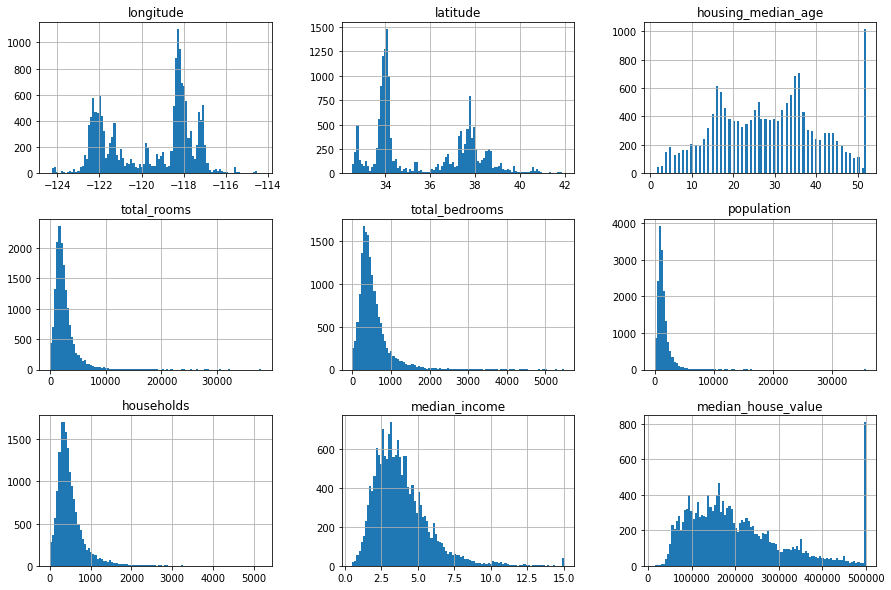

In [6]:
df.hist(bins=100, figsize=(15,10))
plt.show()

In [7]:
class DataManager:
    
    def __init__(self):

        self.bc_exps = {}
        self.scaler = None

    def transform(self, df):
        
        # Clean data
        
        pre_cleaning_len = len(df)
        df = df.query("housing_median_age<52 and median_house_value < 500001").dropna()
        print("Dataframe cleaning: len(df):", pre_cleaning_len, "->", len(df))
        
        # Compute features
        
        ocean_proximity_map = {
            k: j for j, k in enumerate(df.groupby("ocean_proximity").median_house_value.median().sort_values().index)
        }
        
        df["ocean_proximity_"] = df.ocean_proximity.map(ocean_proximity_map)

        df["rooms_per_house"] = df.total_rooms/df.households
        df["bedrooms_per_house"] = df.total_bedrooms/df.households
        df["bedrooms_per_room"] = df.total_bedrooms/df.total_rooms
        
        # Apply BoxCox transformations
        
        for f in df.columns:
            try:
                if f in self.bc_exps.keys():
                    df[f+"_bc"] = stats.boxcox(df[f], lmbda=self.bc_exps[f])
                else:
                    df[f+"_bc"], self.bc_exps[f] = stats.boxcox(df[f])
            except:
                pass
            
        # Scale and eliminate outliers
        num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
        
        if self.scaler is None:
            self.scaler = RobustScaler().fit(X=df[num_cols])
            
        df[[c+"_S" for c in num_cols]] = self.scaler.transform(df[num_cols])
        
        for f in [c+"_S" for c in num_cols]:
            df[f] = 1/(1+np.exp(-df[f]))-.5
            
        print("Features computed")
        
        print("Dataframe transformed")
        
        return df

dm = DataManager()
df = dm.transform(df)
df.head(10)

Dataframe cleaning: len(df): 16452 -> 14646
Features computed
Dataframe transformed


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,housing_median_age_bc_S,total_rooms_bc_S,total_bedrooms_bc_S,population_bc_S,households_bc_S,median_income_bc_S,median_house_value_bc_S,rooms_per_house_bc_S,bedrooms_per_house_bc_S,bedrooms_per_room_bc_S
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,...,0.192579,0.057224,0.133232,0.000000,0.119597,-0.190062,0.095685,-0.157436,0.164973,0.176519
15,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,...,0.274311,-0.185505,-0.131559,-0.159119,-0.136498,-0.183401,-0.067013,-0.166922,0.062120,0.158147
18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,...,0.274311,0.014124,0.009975,-0.061492,0.002733,-0.203470,-0.026271,0.021669,0.095930,-0.002663
20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,...,0.169484,-0.270183,-0.234148,-0.272722,-0.245503,-0.299919,-0.050264,-0.115628,0.146078,0.138069
25,-122.28,37.85,41.0,535.0,123.0,317.0,119.0,2.4038,107500.0,NEAR BAY,...,0.181157,-0.324528,-0.306007,-0.312979,-0.303908,-0.142400,-0.146151,-0.120725,-0.040006,0.093655
26,-122.28,37.85,49.0,1130.0,244.0,607.0,239.0,2.4597,93800.0,NEAR BAY,...,0.265061,-0.183349,-0.169975,-0.192668,-0.162690,-0.134331,-0.182776,-0.079441,-0.075931,0.046190
30,-122.28,37.84,49.0,1916.0,447.0,863.0,378.0,1.9274,122300.0,NEAR BAY,...,0.265061,-0.035457,0.004306,-0.101696,-0.030414,-0.213084,-0.108771,-0.021749,0.272422,0.104229
33,-122.27,37.83,49.0,1655.0,366.0,754.0,329.0,1.3750,104900.0,NEAR BAY,...,0.265061,-0.080043,-0.057897,-0.138760,-0.073407,-0.297299,-0.152952,-0.028046,0.154456,0.064662
34,-122.27,37.83,51.0,2665.0,574.0,1258.0,536.0,2.7303,109700.0,NEAR BAY,...,0.283282,0.071084,0.085400,0.013594,0.084604,-0.096112,-0.140451,-0.037727,0.059434,0.044210
35,-122.27,37.83,49.0,1215.0,282.0,570.0,264.0,1.4861,97200.0,NEAR BAY,...,0.265061,-0.165320,-0.132513,-0.206968,-0.136498,-0.280346,-0.173506,-0.101636,0.052598,0.100529


# Feature exploration

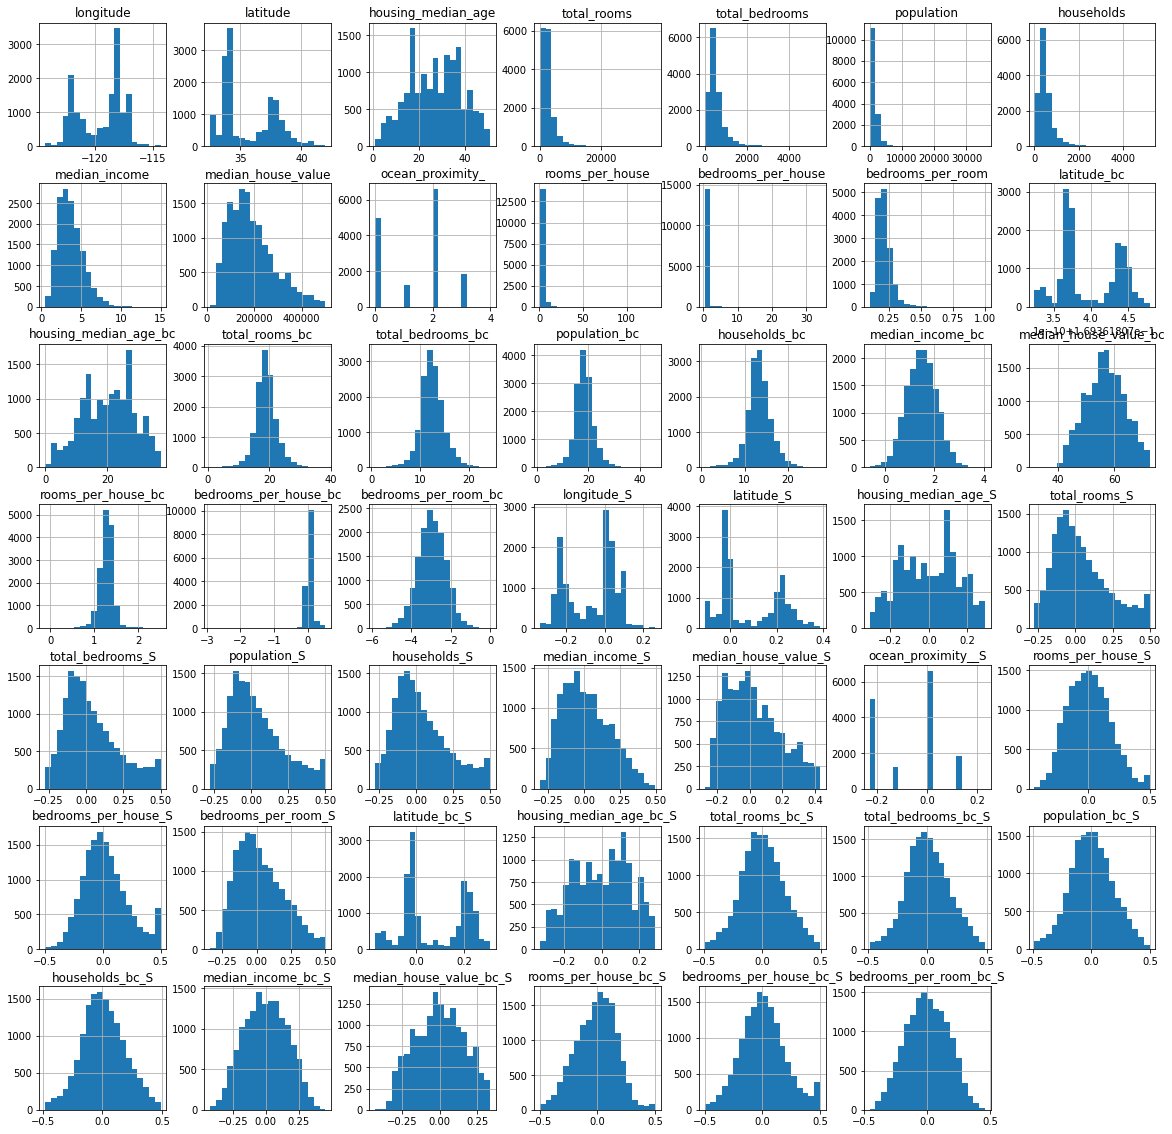

In [8]:
df.hist(bins=20, figsize=(20,20))
plt.show()

In [9]:
df.corr().median_house_value.abs().sort_values(ascending=False).index

Index(['median_house_value', 'median_house_value_S', 'median_house_value_bc',
       'median_house_value_bc_S', 'median_income', 'median_income_S',
       'median_income_bc_S', 'median_income_bc', 'ocean_proximity_',
       'ocean_proximity__S', 'bedrooms_per_room_bc', 'bedrooms_per_room_bc_S',
       'bedrooms_per_room_S', 'rooms_per_house_S', 'bedrooms_per_room',
       'rooms_per_house_bc_S', 'total_rooms_bc_S', 'total_rooms_S',
       'rooms_per_house_bc', 'total_rooms_bc', 'latitude', 'latitude_S',
       'latitude_bc', 'total_rooms', 'latitude_bc_S', 'bedrooms_per_house_S',
       'bedrooms_per_house_bc_S', 'rooms_per_house', 'households_bc_S',
       'households_S', 'households_bc', 'bedrooms_per_house_bc', 'households',
       'total_bedrooms_S', 'total_bedrooms_bc_S', 'total_bedrooms_bc',
       'total_bedrooms', 'bedrooms_per_house', 'longitude', 'population_bc',
       'longitude_S', 'population_bc_S', 'housing_median_age_S',
       'housing_median_age_bc_S', 'housing_median

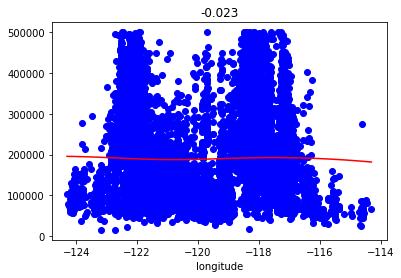

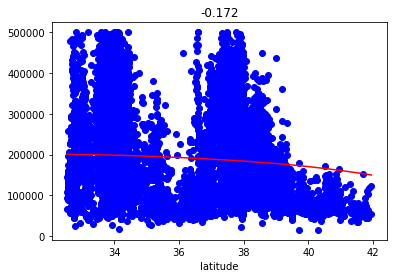

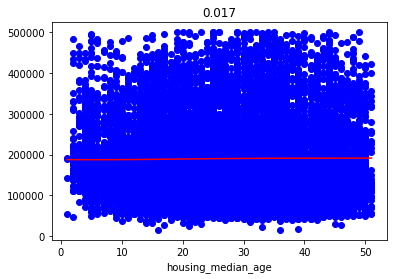

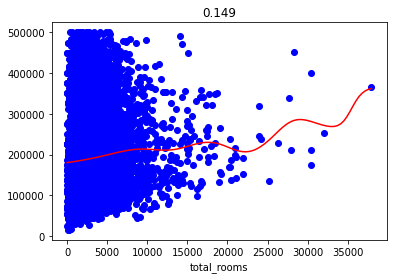

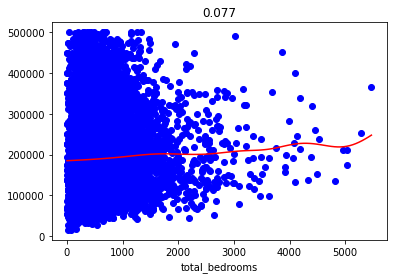

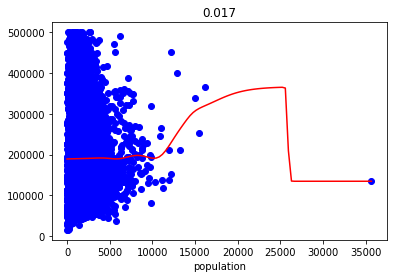

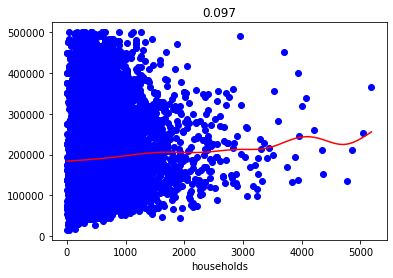

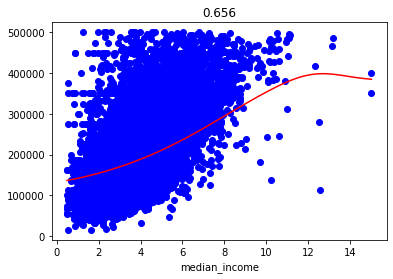

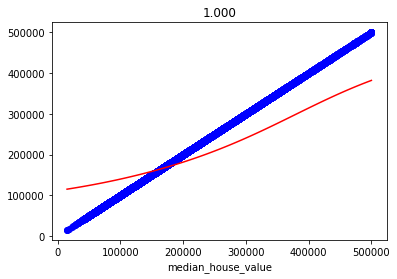

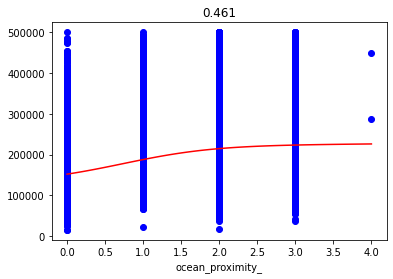

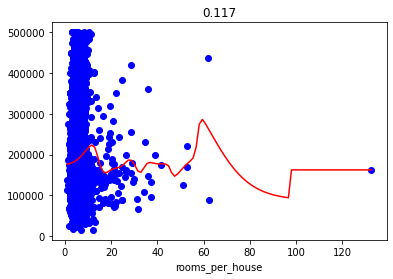

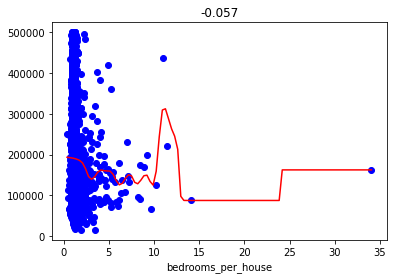

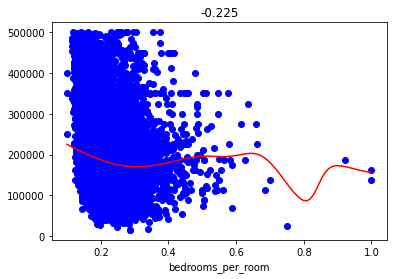

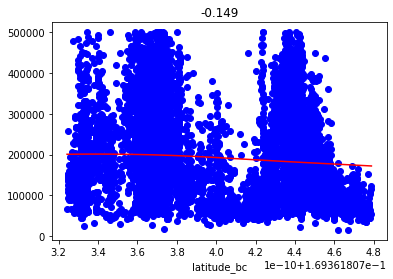

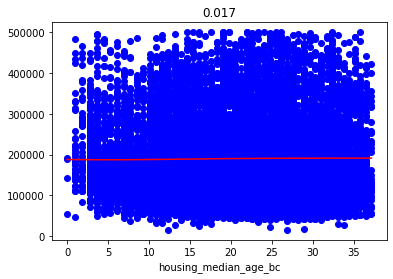

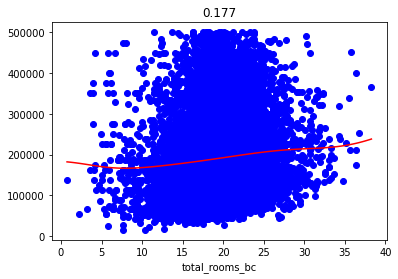

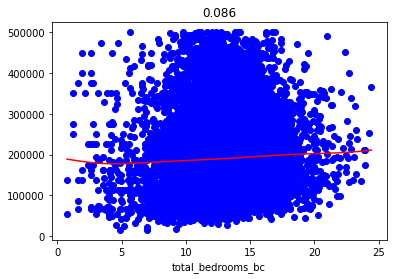

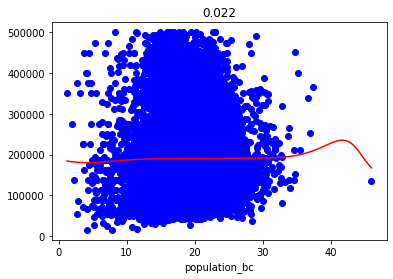

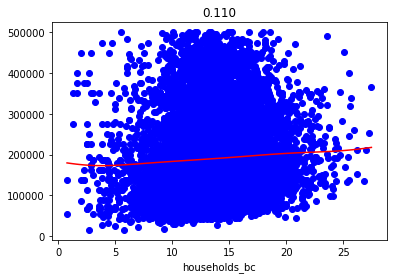

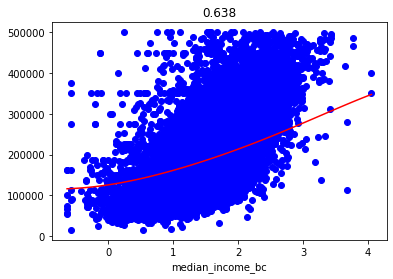

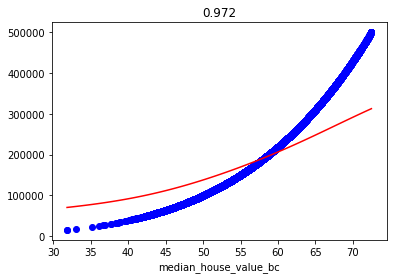

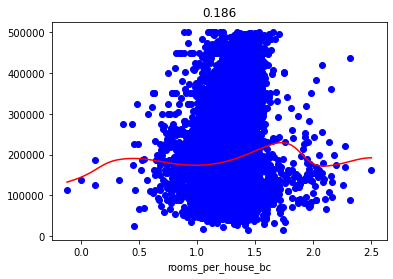

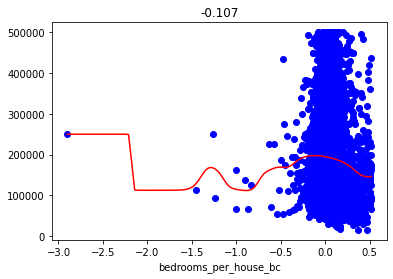

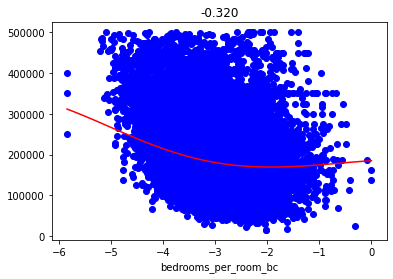

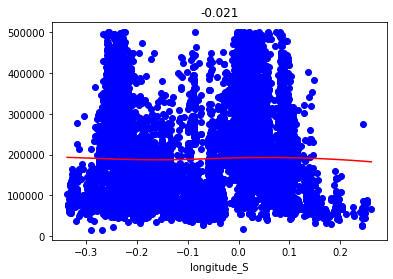

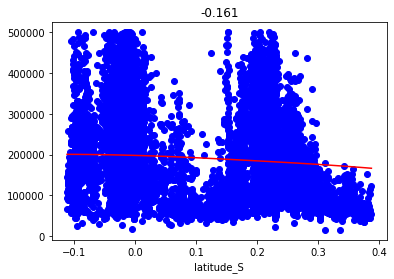

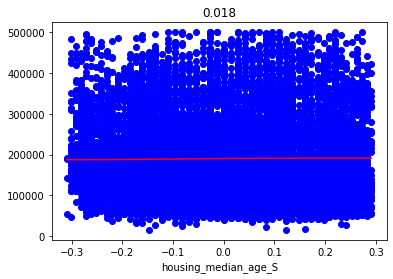

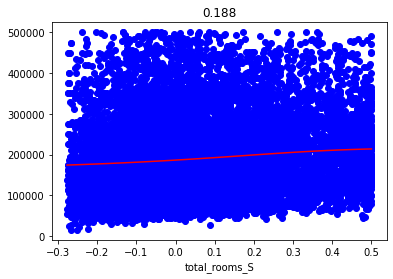

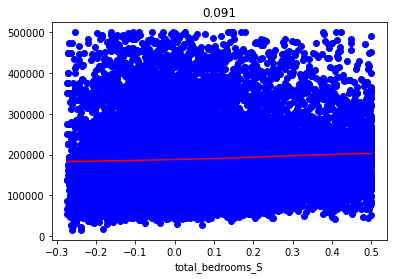

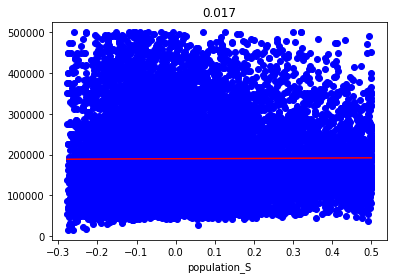

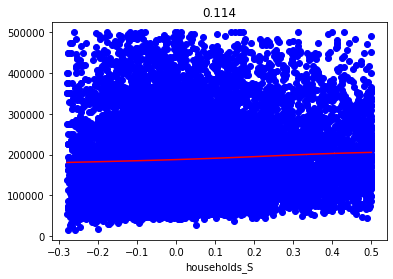

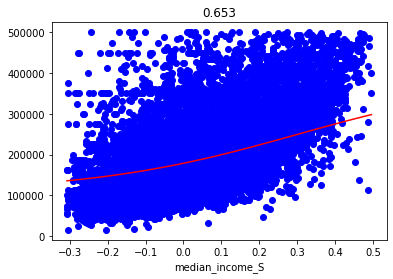

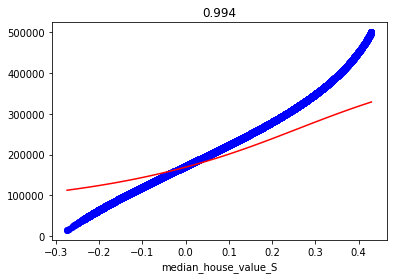

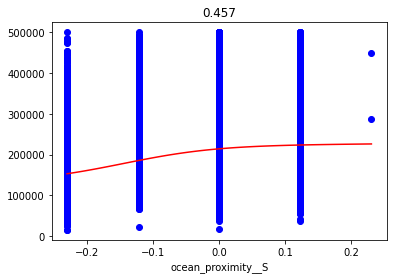

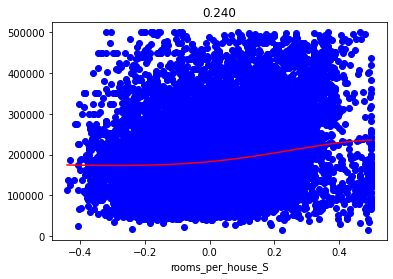

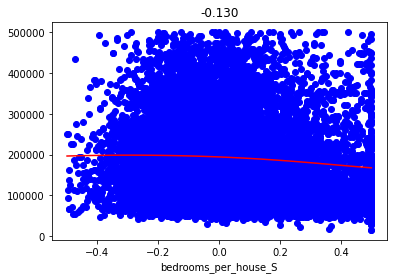

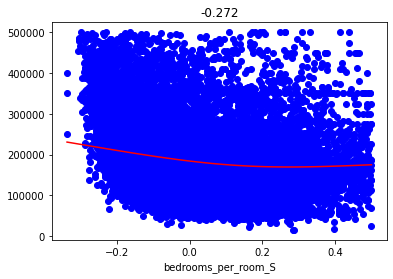

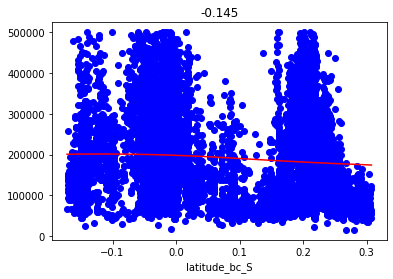

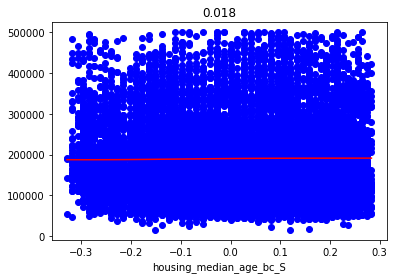

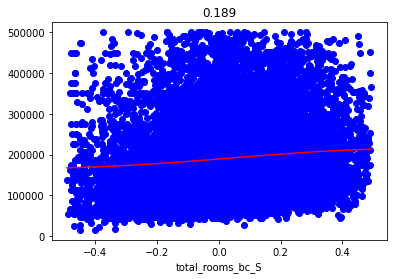

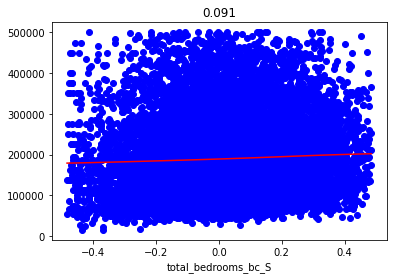

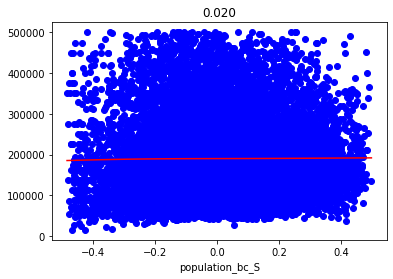

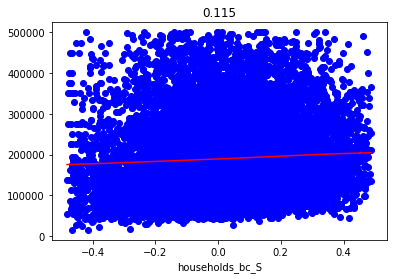

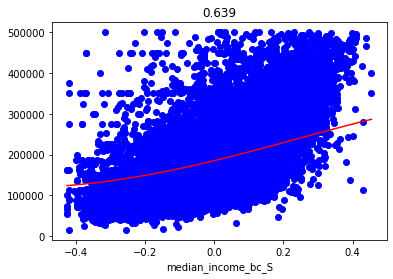

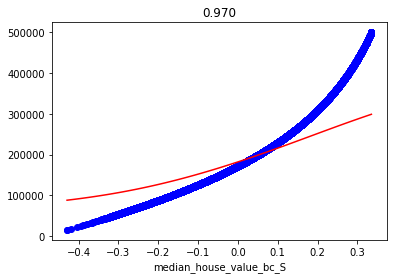

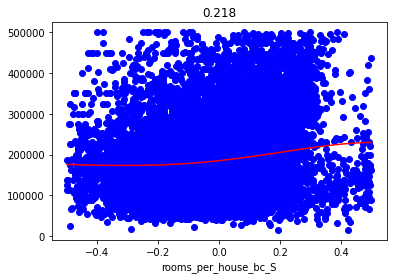

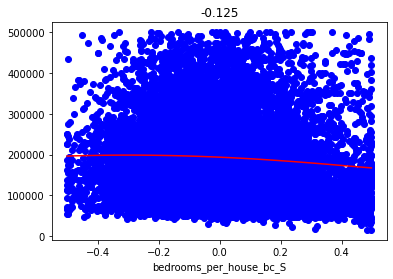

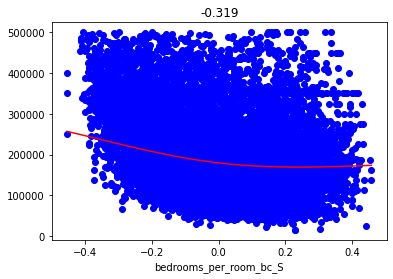

In [10]:
for f in df.columns:
    try:
        x, y = df[f], df.median_house_value
        xs, ys = smooth1D(x, y)
        plt.figure()
        plt.plot(x, y, 'bo')
        plt.plot(xs, ys, 'r-')
        plt.xlabel(f)
        plt.title("%.3f"%np.corrcoef(x, y)[0,1])
        plt.show()
        
    except:
        pass

# Linear regression

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

features = [
    "bedrooms_per_room_bc_S", 
    "ocean_proximity_", 
    "median_income_bc_S",
    "latitude",
    "longitude",
]
target = "median_house_value_bc"

X, y = df[features].values, df[target].values

reg = LinearRegression().fit(X, y)
cv_scores = cross_val_score(reg, X, y, cv=10)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)))

cv_score: 48.82 +- 15.50


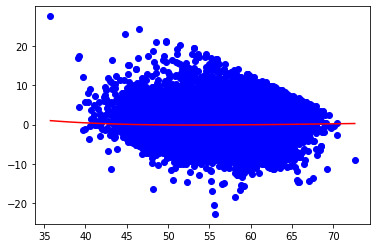

In [146]:
y_hat = reg.predict(X)
xs, ys = smooth1D(y_hat, y-y_hat)
plt.plot(y_hat, y-y_hat, "bo")
plt.plot(xs, ys, "r-")

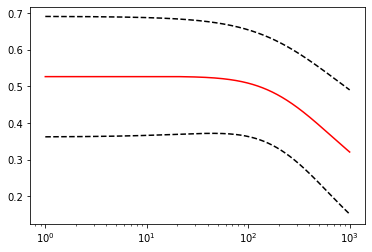

In [214]:
from sklearn.linear_model import Ridge

alphas = np.logspace(0,3,1000)
cv_scores_mean = []; cv_scores_std = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=0)
    cvs = cross_val_score(ridge, X, y, cv=5)
    cv_scores_mean.append(np.mean(cvs))
    cv_scores_std.append(np.std(cvs))
cv_scores_mean = np.array(cv_scores_mean); cv_scores_std = np.array(cv_scores_std)
    
plt.semilogx(alphas, cv_scores_mean, 'r-')
plt.semilogx(alphas, cv_scores_mean+cv_scores_std, 'k--')
plt.semilogx(alphas, cv_scores_mean-cv_scores_std, 'k--')

In [215]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5, alphas=np.logspace(-10,1,100)).fit(X, y)
cv_scores = cross_val_score(ridge, X, y, cv=10)
print("alpha:", ridge.alpha_)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)))
# ridge.score(X, y)

alpha: 10.0
cv_score: 47.67 +- 16.60


In [216]:
from sklearn.ensemble import RandomForestRegressor

features = [
#     "bedrooms_per_room_bc_S", 
    "ocean_proximity_", 
    "median_income_bc_S",
    "longitude",
    "latitude",
]
target = "median_house_value_bc"

X, y = df[features].values, df[target].values

rf = RandomForestRegressor(
    n_estimators=100, 
    max_features="sqrt", 
    max_depth=12, 
    oob_score=True, 
    random_state=0, 
    max_samples=.5
).fit(X,y)

cv_scores = cross_val_score(rf, X, y, cv=5)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)), "\n")

for f, fi in zip(features, rf.feature_importances_):
    print(f, fi)

cv_score: 56.73 +- 14.47 

ocean_proximity_ 0.2799171286238621
median_income_bc_S 0.41816016480980245
longitude 0.14236788948178472
latitude 0.15955481708455072


In [217]:
from sklearn.model_selection import GridSearchCV

?GridSearchCV

gs = GridSearchCV(estimator=rf, param_grid={"max_depth": [2, 4, 6, 12], "max_features": ["auto", "sqrt"]}, cv=5).fit(X, y)

In [219]:
gs.best_estimator_

RandomForestRegressor(max_depth=12, max_features='sqrt', max_samples=0.5,
                      oob_score=True, random_state=0)

In [218]:
gs.cv_results_

{'mean_fit_time': array([0.55714145, 0.40543847, 0.77022305, 0.53264213, 0.97032928,
        0.68049164, 1.65408149, 1.22452979]),
 'std_fit_time': array([0.03008938, 0.00668518, 0.03763905, 0.01472229, 0.01484392,
        0.02734393, 0.02815295, 0.08167873]),
 'mean_score_time': array([0.01555867, 0.01804976, 0.02059464, 0.02017102, 0.02180891,
        0.02549357, 0.04142246, 0.04040751]),
 'std_score_time': array([2.38878878e-03, 2.32635541e-03, 8.09849839e-04, 1.53283679e-05,
        3.19574088e-03, 3.98871166e-03, 1.94957900e-03, 1.35499471e-03]),
 'param_max_depth': masked_array(data=[2, 2, 4, 4, 6, 6, 12, 12],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'sqrt', 'auto', 'sqrt', 'auto', 'sqrt', 'auto',
                    'sqrt'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=

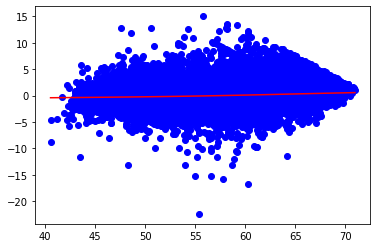

In [201]:
y_hat = rf.predict(X)
xs, ys = smooth1D(y_hat, y-y_hat)
plt.plot(y_hat, y-y_hat, "bo")
plt.plot(xs, ys, "r-")

# Final evaluation

In [17]:
df_test = dm.transform(df_test)

Dataframe cleaning: len(df): 4188 -> 3733
Features computed
Dataframe transformed


In [18]:
len(df_test)

3733

In [136]:
X_test, y_test = df_test[features].values, df_test[target].values
est.score(X_test, y_test)

0.7854579915831466

In [92]:
from sklearn.metrics import r2_score

y_test_hat = inv_boxcox(est.predict(X_test), dm.bc_exps['median_house_value'])

r2_score(df_test.median_house_value, y_test_hat)

0.7437774062359763

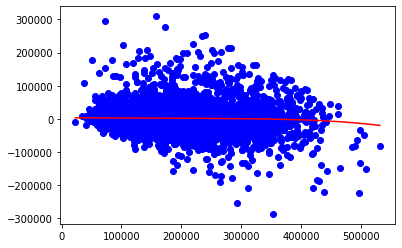

In [78]:
xs, ys = smooth1D(y_test_hat, df_test.median_house_value-y_test_hat)
plt.plot(y_test_hat, df_test.median_house_value-y_test_hat, "bo")
plt.plot(xs, ys, "r-")

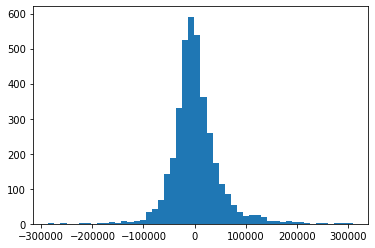

In [81]:
plt.hist(df_test.median_house_value-y_test_hat, bins=50)
plt.show()

In [85]:
100*np.std(df_test.median_house_value-y_test_hat)/df_test.median_house_value.mean()

24.86521227975323